In [1]:
# if running from 'examples' directory of p2prev repo, 
# we need to add parent directory to module search path
# so that p2prev module can be imported
# (not necessary if you've pip installed p2prev module)
import sys
import os
cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(pardir)

In [2]:
import pymc as pm
import arviz as az
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from p2prev import PCurveWithinGroupDifference

We'll start by loading some data from [Veillette et al. (2023)](https://doi.org/10.1523/JNEUROSCI.1116-23.2023). In this experimen, electrical muscle stimulation of the forearm was used to move subjects' muscles for them while they tried to complete a reaction time task volitionally. Subjects were asked, after each trial, whether they or the muscle stimulator caused the muscle movement. Stimulation timing was adaptively tuned to the latency threshold at which 50% of movements were perceived as self-caused. 

The data loaded below contains (1) precomputed _p_-values for the behavioral sensitivity of subjects' agency judgments to variation of the stimulation latency around the threshold estimated by the adaptive procedure and (2) within-subject decoding performances (area under the receiver operator characteristic curve of AUROC) for predicting trial-by-trial agency judgments from EEG, with permutation null distributions. AUROCs are available for many time points surrounding the time of muscle stimulation, so we can estimate prevalence either for the whole trial/epoch or for each time point individually. 

In [3]:
# load data
ps_behav = np.load(join('resources', 'eeg', 'pvals_behav.npy'))
times = np.load(join('resources', 'eeg', 'timestamps.npy'))
H0 = np.load(join('resources', 'eeg', 'H0_auroc.npy'))

print('(n_permutations, n_times, n_subjects) = (%d, %d, %d)'%H0.shape)

# compute per-subject familywise error rate corrected p-values 
# using max-stat FWER correction re Nichols & Holmes (2002)
# (note: first "permutation" in array is observed AUROC)
ps_eeg = (H0.max(1)[:, np.newaxis, :] >= H0[0]).mean(0) 
ps_eeg[ps_eeg == 1] -= 1e-7 # b/c p-values of 1 aren't technically possible
# but can occur in a permutation test anyway as a numerical artifact

(n_permutations, n_times, n_subjects) = (5001, 36, 23)


As suggested by [Ince et al. (2021)](https://doi.org/10.7554/eLife.62461), the lowest familywise error rate correcte _p_-value for each subject, obtained across all time points, can be seen as a global _p_-value for a subject -- here corresponding to a test of the null hypothesis that the subject shows above-chance decoding at any time across the whole epoch. 

In [4]:
# lowest FWER-corrected p-val across time is global p-val for subject
ps_eeg_sub = ps_eeg.min(0)

We'll fit a within-group difference prevalence model, allowing us to compare the prevalence of behavioral sensitivity around threshold and of above-chance decoding of behavior.

In [5]:
mod = PCurveWithinGroupDifference(ps_behav, ps_eeg_sub)
mod.fit()
mod.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effect_size[0],2.306,0.295,1.767,2.860,0.005,0.003,3926.0,2905.0,1.0
effect_size[1],3.388,0.209,2.976,3.762,0.003,0.002,4232.0,3083.0,1.0
effect_size_diff,1.083,0.357,0.428,1.773,0.006,0.004,4024.0,3489.0,1.0
prevalence_H1,0.655,0.107,0.473,0.870,0.002,0.001,4644.0,3883.0,1.0
prevalence_H2,0.922,0.051,0.831,0.996,0.001,0.001,4299.0,3337.0,1.0
prevalence_diff,0.268,0.114,0.054,0.479,0.002,0.001,3997.0,3944.0,1.0


In [6]:
decoding_prev = mod.prevalence_H2 # save posterior samples for plotting later
az.hdi(decoding_prev, hdi_prob = .95) 

array([0.8221053, 0.9958289])

The prevalence of above-chance decoding of agency judgments from EEG (i.e. $H_2$ here) exceeds that of behaviorally sensitivity. The prevalence model also allows us to estimate $\mathbb{P}(H_2|H_1)$, i.e. the conditional prevalence of $H_2$ given that $H_1$ is true, and $\mathbb{P}(H_2|H_0)$. This allows us to evaluate the plasubility of claims in the form of "the prevalence of $H_2$ is higher among people for whom $H_1$ is true."

Let's get a 95% credible intervals for those quantities.

In [7]:
hdi = az.hdi(mod.prob_H2_given_H0, hdi_prob = .95)
m = mod.prob_H2_given_H0.mean()
print('Posterior mean = %.03f, HDI [%.03f, %.03f]'%(m, hdi[0], hdi[1]))

Posterior mean = 0.881, HDI [0.668, 1.000]


In [8]:
hdi = az.hdi(mod.prob_H2_given_H1, hdi_prob = .95)
m = mod.prob_H2_given_H1.mean()
print('Posterior mean = %.03f, HDI [%.03f, %.03f]'%(m, hdi[0], hdi[1]))

Posterior mean = 0.942, HDI [0.835, 1.000]


We can also estimate the posterior of their difference. This estimate is interpreted much like the between-group prevalence difference estimated in other tutorials, but $H_0$ and $H_1$ group membership is inferred from the data instead of known _a priori;_ uncertainty about group assignments is appropriately accounted for in the conditional prevalence estimates.

In [9]:
diff = mod.prob_H2_given_H1 - mod.prob_H2_given_H0
hdi = az.hdi(diff, hdi_prob = .95)
m = diff.mean()
print('Posterior mean = %.03f, HDI [%.03f, %.03f]'%(m, hdi[0], hdi[1]))

Posterior mean = 0.061, HDI [-0.169, 0.321]


There doesn't appear to be strong evidence of difference in the prevalence of above-chance decoding _over the whole epoch_ contingent upon $H_1$ being true. However, we can also estimate these quantities, and their difference, for each time point following stimulation, since we have _p_-values for each time. In other words, even though there isn't a difference in _whether_ agency judgments can be decoded, there may still be a difference in _when_ they can be decoded. 

>**Warning:** The below code chunk can take quite a long time to run! (As it fits a seperate model at each time.)

In [10]:
# ceate emmpty lists in which to aggregate results across time 
prev = []
prev_given_H0 = []
prev_given_H1 = []

# should use uncorrected p-values for time-by-time inference
# (since we want p-val distribution to be uniform under the
# null hypothesis to meet assumptions of our Bayesian model)
ps_eeg_uncorr = (H0 >= H0[0]).mean(0) 
ps_eeg_uncorr[ps_eeg_uncorr == 1] -= 1e-7

for t in range(times.size):
    # fit within-group prevalence model at each timepoint
    mod = PCurveWithinGroupDifference(ps_behav, ps_eeg_uncorr[t], progressbar = False)
    mod.fit()
    # save posterior samples for conditional probabilities
    prev.append(mod.prevalence_H2)
    prev_given_H0.append(mod.prob_H2_given_H0)
    prev_given_H1.append(mod.prob_H2_given_H1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 11 seconds.


/tmp/ipykernel_166487/638856069.py:23: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(samples, hdi_prob = .95)
/tmp/ipykernel_166487/638856069.py:23: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(samples, hdi_prob = .95)
/tmp/ipykernel_166487/638856069.py:23: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(samples, hdi_prob = .95)


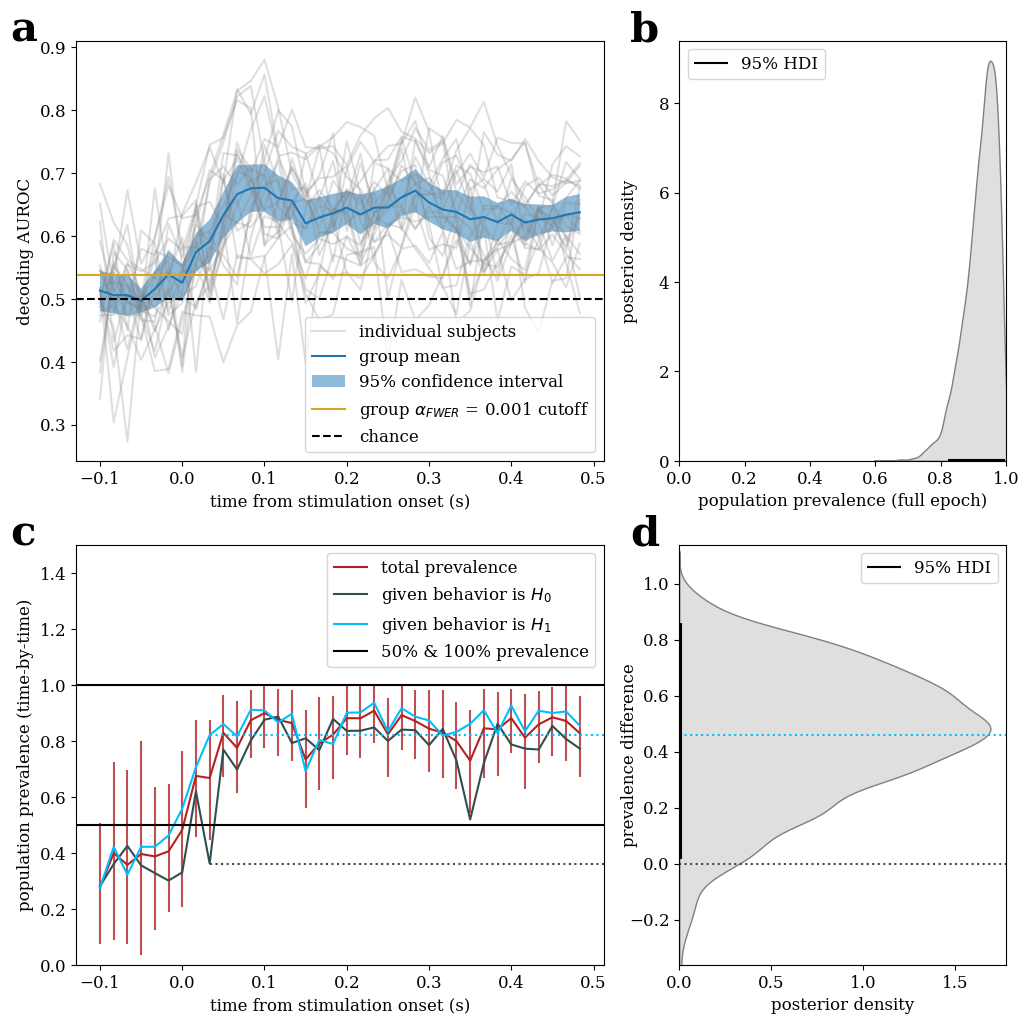

In [11]:
prev_both = np.stack(prev, axis = 1) 
prev1 = np.stack(prev_given_H1, axis = 1) 
prev0 = np.stack(prev_given_H0, axis = 1)
delta = prev1 - prev0
prob_diff = (delta > 0).mean(0)
max_idx = np.argmax(prob_diff)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

def add_label(ax, label, x_offset = -.125, y_offset = 0, size = 30):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin + x_offset*xscale, ymax + yscale*y_offset, 
        label, size = size, weight = 'bold'
    )
    
def plot_posterior(ax, samples, color = 'blue', offset = 0, label = ''):
    hdi = az.hdi(samples, hdi_prob = .95)
    ax.plot(times + offset, samples.mean(0), color = color, label = label)
    if label == 'total prevalence':
        ax.vlines(times + offset, hdi[:, 0], hdi[:, 1], color = color, alpha = .8)


fig = plt.figure(figsize = (12, 12))
gs = gridspec.GridSpec(2, 5, wspace = .6, hspace = .2)

ax = fig.add_subplot(gs[0, :3])
for i in range(H0.shape[-1]):
    label = 'individual subjects' if i == 0 else None
    ax.plot(times, H0[0, :, i], color = 'gray', alpha = .25, label = label)
auroc = H0.mean(-1)[0]
auroc_se = H0.std(-1)[0]/np.sqrt(H0.shape[-1])
ax.plot(times, auroc, label = 'group mean')
ax.fill_between(times, auroc - 2*auroc_se, auroc + 2*auroc_se, alpha = .5, label = '95% confidence interval')
ax.set_ylabel('decoding AUROC')
ax.set_xlabel('time from stimulation onset (s)')
# compute group-level familywise error rate corrected threshold
h0 = H0.mean(-1) # average null samples across subjects
h0_max = h0.max(1) # max stat across time re Nichols & Holmes (2002)
auroc_max_alpha = 0.001 # and FWER thres is 1 - alpha quantile of null
auroc_max_thres = np.quantile(h0_max, 1 - auroc_max_alpha)
ax.axhline(auroc_max_thres, color = 'goldenrod', label = r'group $\alpha_{FWER}$ = %.03f cutoff'%auroc_max_alpha)
ax.axhline(0.5, color = 'black', label = 'chance', linestyle = '--')
ax.legend(loc = 'lower right')
add_label(ax, 'a')
add_label(ax, 'b', 1.05)

# plot whole-epoch prevalence results
ax = fig.add_subplot(gs[0, -2:])
sns.kdeplot(x = decoding_prev, ax = ax, color = 'grey', fill = True)
hdi = az.hdi(decoding_prev, hdi_prob = .95)
ax.hlines(.025, hdi[0], hdi[1], label = '95% HDI', color = 'black')
ax.set_ylabel('posterior density')
ax.yaxis.set_label_coords(-.125, .5)
ax.set_xlabel('population prevalence (full epoch)')
ax.set_xlim(0, 1)
ax.legend(loc = 'upper left')

ax = fig.add_subplot(gs[1, :3])
plot_posterior(ax, prev_both, 'firebrick', label = r'total prevalence')
plot_posterior(ax, prev0, 'darkslategrey', label = r'given behavior is $H_0$')
plot_posterior(ax, prev1, 'deepskyblue', label = r'given behavior is $H_1$')
ax.set_xlabel('time from stimulation onset (s)')
ax.set_ylabel('population prevalence (time-by-time)')
xmin, xmax = ax.get_xlim()
xrange = np.abs(xmax - xmin)
t = (times[max_idx] - xmin)/xrange
ax.axhline(prev0.mean(0)[max_idx], xmin = t, color = 'darkslategrey', linestyle = 'dotted')
ax.axhline(prev1.mean(0)[max_idx], xmin = t, color = 'deepskyblue', linestyle = 'dotted')
ax.axhline(.5, label = '50% & 100% prevalence', color = 'black')
ax.axhline(1., color = 'black')
ax.legend()
ax.set_ylim(0, 1.5)
ymin, ymax = ax.get_ylim()
add_label(ax, 'c')
add_label(ax, 'd', 1.05)

ymin -= prev0.mean(0)[max_idx]
ymax -= prev0.mean(0)[max_idx]
ax = fig.add_subplot(gs[1, -2:])
ax.set_ylim(ymin, ymax)
ax.axhline(0, color = 'darkslategrey', linestyle = 'dotted')
ax.axhline(prev1.mean(0)[max_idx] - prev0.mean(0)[max_idx], color = 'deepskyblue', linestyle = 'dotted')
ax.set_ylabel('prevalence difference')
ax.set_xlabel('posterior density')
ax.yaxis.set_label_coords(-.125, .5)
sns.kdeplot(y = delta[:, max_idx], ax = ax, color = 'grey', fill = True)
hdi = az.hdi(delta[:, max_idx])
ax.vlines(.012, hdi[0], hdi[1], color = 'black', label = '95% HDI')
ax.legend()

f = os.path.join('figures', 'eeg-decoding.jpeg')
plt.savefig(f, dpi = 500, bbox_inches = 'tight')
plt.show()

In [12]:
def print_mean_hdi(x):
    m = x.mean()
    hdi = az.hdi(x)
    print('mean = %.03f, HDI = [%.03f, %.03f]'%(m, hdi[0], hdi[1]))
    
print('At %.03f seconds the prevalence difference is'%times[max_idx])
print_mean_hdi(delta[:, max_idx])

At 0.033 seconds the prevalence difference is
mean = 0.458, HDI = [0.016, 0.861]


In [13]:
print('given H1 is false, H2 prevalence is:')
print_mean_hdi(prev0[:, max_idx])

given H1 is false, H2 prevalence is:
mean = 0.361, HDI = [0.022, 0.688]


In [14]:
print('given H1 is true, H2 prevalence is:')
print_mean_hdi(prev1[:, max_idx])

given H1 is true, H2 prevalence is:
mean = 0.820, HDI = [0.588, 1.000]


In [15]:
print('while total prevalence is:')
print_mean_hdi(prev_both[:, max_idx])

while total prevalence is:
mean = 0.667, HDI = [0.462, 0.874]


A last note is that, while it is redundant to report a post-hoc power estimate for a group-mean significance test, it is perfectly valid to estimate the Bayesian predictive power of a within-subject NHST given repeated observations of within-subject _p_-values. This is particularly handy for analyses/tests for which it would otherwise be hard to estimate power, such as permutation tests on EEG decoding results as we have here.

Predictive power calculations are not currently implemented in the `PCurveWithinGroupDifference` class, but they are implemented in the standard `PCurveMixture` class.

In [16]:
from p2prev import PCurveMixture
mod = PCurveMixture(ps_eeg_sub, target_accept = .95)
mod.fit()

alpha = 0.05 # false positive rate at which to estimate power
hdi_prob = .95
m = mod.posterior_predictive_power(alpha).power.mean()
hdi = mod.posterior_predictive_power_hdi(alpha, hdi_prob)
print('Posterior predictive power at alpha = %.02f has expectation = %.03f, %d%% HDI:'%(alpha, m, 100*hdi_prob), hdi)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 8 seconds.


Output()

Posterior predictive power at alpha = 0.05 has expectation = 0.956, 95% HDI: [0.91837599 0.98847378]


Note that this power estimate pertains to replications of the same within-subject experimental design; it is not simple to extend this approach to estimate what power _would_ be with e.g. a larger trial count. However, since it's a Bayesian estimate, you get a credible interval too! (Unlike most power analyses, which yield point estimates without uncertainty quantification... even though most power calculations based on small pilot samples can [vary hugely from actual power](https://doi.org/10.1177/1745691614528520).) 